<a href="https://colab.research.google.com/github/shreshthsk/MLProjects/blob/main/DogBreedPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dog Breed Prediction

In [ ]:
#import files
from google.colab import files
files.upload()

{}

Connect Kaggle API

In [ ]:
!pip install -q kaggle

Root folder for kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Directory for dogdataset

In [ ]:
!mkdir dog_dataset
%cd dog_dataset

mkdir: cannot create directory ‘dog_dataset’: File exists
/content/dog_dataset


In [ ]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           3758          8  0.1764706        


Download dataset

In [ ]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 688M/691M [00:24<00:00, 33.3MB/s]
100% 691M/691M [00:24<00:00, 29.1MB/s]
/content


Unzipping dataset and remove unusable files

In [ ]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam

Data Preprocessing

In [ ]:
#Read the labels.csv
labels = pd.read_csv("dog_dataset/labels.csv")
print(labels.shape)
labels.head(5)

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#Visualize numbers of breeds
breeds_all = labels["breed"]
breed_count = breeds_all.value_counts()
breed_count.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [ ]:
#Selection of three breeds
CLASS_NAMES = ['scottish_deerhound','maltese_dog','entlebucher']
label = labels[(labels['breed'].isin(CLASS_NAMES))]
label = label.reset_index()
label.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


Transformation

In [ ]:
#Matrix with zeros
X_data = np.zeros((len(label),224,224,3),dtype = 'float32')
#OneHotEncoding
Y_data = label_binarize(label['breed'],classes = CLASS_NAMES)

#Reading and Converting image to numpy array and normalizing dataset
for i in tqdm(range(len(label))):
  img = image.load_img('dog_dataset/train/%s.jpg' % label['id'][i],target_size = (224,224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(),axis = 0)
  X_data[i] = x/255.0
print('\nTrain Images Shape: ',X_data.shape,'Size :{:,}'.format(X_data.size))
print('One Hot Encoded Output Shape: ',Y_data.shape,'Size :{:,}'.format(Y_data.size))

100%|██████████| 358/358 [00:01<00:00, 191.53it/s]


Train Images Shape:  (358, 224, 224, 3) Size :53,889,024
One Hot Encoded Output Shape:  (358, 3) Size :1,074


Building the Model

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5),activation = 'relu',input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),activation = 'relu',kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7),activation = 'relu',kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5),activation = 'relu',kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(128,activation = "relu" ,kernel_regularizer = "l2"))
model.add(Dense(64,activation = "relu" ,kernel_regularizer = "l2"))
model.add(Dense(len(CLASS_NAMES),activation = "softmax"))

model.compile(loss = 'categorical_crossentropy',optimizer = Adam(0.0001),metrics = ['accuracy'])

model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)      

Split the data

In [ ]:
TrainandVal_X_Data, Test_X_Data,TrainandVal_Y_Data, Test_Y_Data = train_test_split(X_data,Y_data,test_size = 0.1)
TrainX, VAlX, TrainY, ValY = train_test_split(TrainandVal_X_Data,TrainandVal_Y_Data, test_size = 0.3)

Training the data

In [14]:
epochs = 100
batch_size = 128

history = model.fit(TrainX,TrainY, batch_size = batch_size, epochs = epochs, validation_data = (VAlX,ValY))

Epoch 1/100
2/2 [==============================] - 41s 21s/step - loss: 4.6364 - accuracy: 0.4489 - val_loss: 4.6430 - val_accuracy: 0.3814
Epoch 2/100
2/2 [==============================] - 41s 20s/step - loss: 4.6068 - accuracy: 0.4711 - val_loss: 4.6155 - val_accuracy: 0.3918
Epoch 3/100
2/2 [==============================] - 41s 20s/step - loss: 4.5769 - accuracy: 0.4756 - val_loss: 4.5878 - val_accuracy: 0.4330
Epoch 4/100
2/2 [==============================] - 41s 21s/step - loss: 4.5461 - accuracy: 0.4844 - val_loss: 4.5579 - val_accuracy: 0.4639
Epoch 5/100
2/2 [==============================] - 47s 26s/step - loss: 4.5124 - accuracy: 0.5067 - val_loss: 4.5290 - val_accuracy: 0.4536
Epoch 6/100
2/2 [==============================] - 41s 20s/step - loss: 4.4786 - accuracy: 0.5111 - val_loss: 4.4988 - val_accuracy: 0.4639
Epoch 7/100
2/2 [==============================] - 49s 21s/step - loss: 4.4429 - accuracy: 0.5289 - val_loss: 4.4670 - val_accuracy: 0.4742
Epoch 8/100
2/2 [===

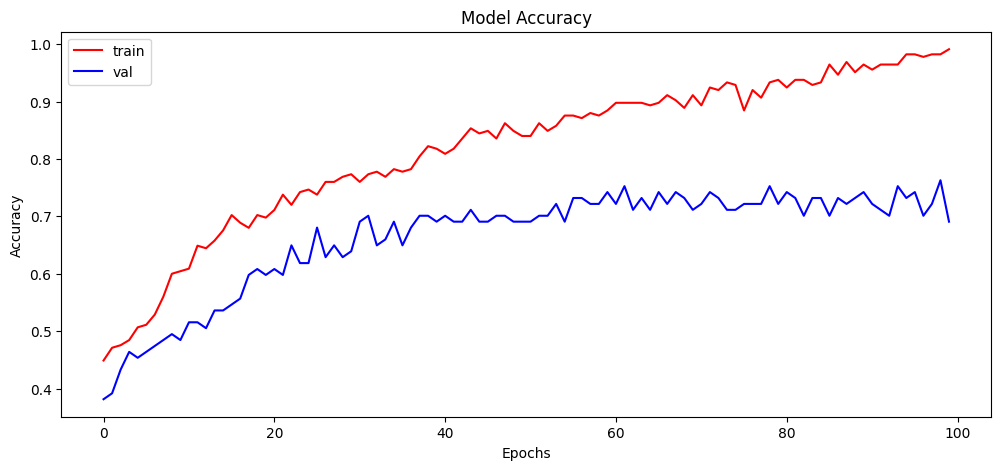

In [15]:
#Visualization
plt.figure(figsize = (12,5))
plt.plot(history.history['accuracy'],color = 'r')
plt.plot(history.history['val_accuracy'],color = 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

Testing

In [16]:
Y_pred = model.predict(Test_X_Data)
score = model.evaluate(Test_X_Data,Test_Y_Data)
print('Accuracy over the test set: \n',round((score[1]*100),2),'%')

2/2 [==============================] - 3s 352ms/step - loss: 2.9620 - accuracy: 0.7222
Accuracy over the test set: 
 72.22 %


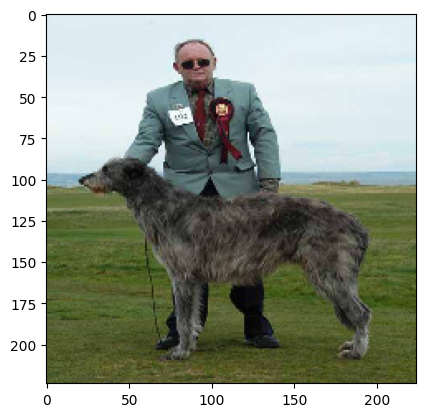

Originally :  scottish_deerhound
Predicted:  scottish_deerhound


In [20]:
plt.imshow(Test_X_Data[5,:,:,:])
plt.show()
print("Originally : ",label['breed'][np.argmax(Test_Y_Data[5])])
print("Predicted: ",label['breed'][np.argmax(Y_pred[5])])